In [1]:
import dadrah.analysis.root_plotting_util as rpu
import dadrah.util.run_paths as runpa
import dadrah.util.string_constants as stco
import pofah.jet_sample as js
import pofah.phase_space.cut_constants as cuts
import dadrah.kfold_pipeline.kfold_string_constants as kstco
import dadrah.selection.selection_util as seut
import dadrah.kfold_pipeline.kfold_util as kutil
import gof_tests.src.string_constants as gstco

import pathlib
import argparse
from typing import List

import numpy as np
import ROOT as rt
import root_numpy as rtnp
import uuid
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import root_numpy as rtnp
import mplhep as hep
plt.style.use(hep.style.ROOT)
from typing import List
from recordtype import recordtype

Welcome to JupyROOT 6.22/00


## run config

In [2]:
Parameters = recordtype('Parameters','qr_run_n, quantiles, qcd_sample_id, sig_sample_id, xsec_sig_training, score_strategy_id, read_n, env_run_n, poly_run_n')
params = Parameters(qr_run_n=416,
                    quantiles=[0.3, 0.5, 0.7, 0.9],
                    qcd_sample_id='qcdSigAll', 
                    sig_sample_id='GtoWW35naReco',
                    xsec_sig_training=0,
                    score_strategy_id='rk5_05',
                    read_n=None,
                    env_run_n=0,
                    poly_run_n=0,
                    )

train_share = 0
xsecs_sig   = [0,20,40,60,80,100] # signal cross sections
mX = 3.5
sample_ids = [params.qcd_sample_id, params.sig_sample_id]

# choose which template quantile to use (0 = 0.9-1.0, 1 = 0.7-0.9)
template_q_idx = 0

# paths
input_path = gstco.get_qr_results_in_data_dir(params)
fig_dir = gstco.get_sel_histograms_out_fig_dir(params)
out_hist_dir = gstco.get_sel_histograms_out_data_dir(params)

In [3]:
# Rescaling the inputs to lumi
xsec_qcd       = 8730000.0 # Crossection in fb             
qcd_gen_events = 134366091.0+199435365.0+90490645.0+134264102.0 #(all generated QCD)
xsec_sig_default = 10. #In units of fb (10 fb == 0.01 pb) 
sig_gen_events = 982038.0 #(all generated signal)
lumi           = qcd_gen_events/xsec_qcd # assuming 64/fb since qcd_gen_events/8730000 ~ 64

scale_qcd = xsec_qcd*lumi/qcd_gen_events
scale_sig = (1-train_share)*xsec_sig_default*lumi/sig_gen_events #inference on full dataset
print('Usign luminosity {}'.format(lumi))
print('Scale {} QCD events with {}'.format(qcd_gen_events,scale_qcd))
print('Scale {} signal events with {} for 10fb default sig xsec'.format(sig_gen_events,scale_sig))

Usign luminosity 63.98123745704467
Scale 558556203.0 QCD events with 1.0
Scale 982038.0 signal events with 0.0006515148849336245 for 10fb default sig xsec


# read in data

In [4]:
samples = {}

for sample_id in sample_ids:
    in_path = os.path.join(input_path,sample_id+'.h5') #paths.in_file_path(sample_id)
    samples[sample_id] = js.JetSample.from_input_file(sample_id, in_path)
    print('read ' + str(len(samples[sample_id])) + ' ' + sample_id + ' samples from ' + in_path)

read 11985958 qcdSigAll samples from /eos/user/k/kiwoznia/data/QR_results/events/qr_run_416/env_run_0/poly_run_0/qcdSigAll.h5
read 531825 GtoWW35naReco samples from /eos/user/k/kiwoznia/data/QR_results/events/qr_run_416/env_run_0/poly_run_0/GtoWW35naReco.h5


### divide into orthogonal quantiles

In [5]:
# qcd
samples_ortho_quantiles_qcd = seut.divide_sample_into_orthogonal_quantiles(samples[params.qcd_sample_id], params.quantiles)
mjj_vals_qcd = [sample_ortho['mJJ'] for sample_ortho in samples_ortho_quantiles_qcd]
# signal
samples_ortho_quantiles_sig = seut.divide_sample_into_orthogonal_quantiles(samples[sample_id_sig], params.quantiles)
mjj_vals_sig = [sample_ortho['mJJ'] for sample_ortho in samples_ortho_quantiles_sig]

In [6]:
num_samples_qcd = sum(map(len,mjj_vals_qcd))
print(num_samples_qcd)
num_samples_sig = sum(map(len,mjj_vals_sig))
print(num_samples_sig)

11985960
531825


In [7]:
quantiles_inv = [round((1.-q),2) for q in [0]+params.quantiles] # invert quantiles to [1.0 0.9, 0.7, 0.5, 0.3, 0.1, 0.01]
q_str_leg = [str(q) for q in quantiles_inv+[0.]]

In [8]:
q_str_leg

['1.0', '0.7', '0.5', '0.3', '0.1', '0.0']

In [9]:
min_mjj = 1200.
max_mjj = 6000. #5600
bin_edges = kutil.get_bins_from_envelope(params)
bin_edges = bin_edges[(bin_edges>=min_mjj) & (bin_edges<=max_mjj)]

print('min_mjj='+str(min_mjj) + ', max_mjj='+str(max_mjj))
print('bin edges')
print(bin_edges)

n_bins = len(bin_edges)-1
max_bin = bin_edges[-1]
min_bin = bin_edges[0]

min_mjj=1200.0, max_mjj=6000.0
bin edges
[1227.5 1287.5 1353.5 1422.  1493.  1566.5 1642.5 1721.  1802.5 1887.
 1974.5 2065.  2158.5 2255.5 2355.5 2459.  2566.  2676.5 2791.  2909.
 3031.  3157.  3287.  3421.5 3561.  3705.  3853.  4006.  4164.5 4328.
 4497.  4671.5 4851.5 5037.5 5229.5 5450.5 5655.5 5844. ]


In [10]:
n_bins

37

### color palettes

In [11]:
cmap_qcd = cm.get_cmap('winter') # 'summer'
cmap_qcd = [mpl.colors.rgb2hex(c) for c in cmap_qcd(np.linspace(0.0, 1.0, len(mjj_vals_qcd)+1))][1:]
cmap_sig = cm.get_cmap('winter')
cmap_sig = [mpl.colors.rgb2hex(c) for c in cmap_sig(np.linspace(0.0, 1.0, len(mjj_vals_sig)+1))][1:]
bump_col = '#e25650' # colors for signal bump

## fill events into histograms

In [12]:
n_bins = len(bin_edges)-1 #50
hist_sz = 700
marker_sty = 8
marker_sz = 0.75

In [13]:
datas_qcd = {}
datas_sig = {}

# qcd template / bottom histogram
props={'LineColor': rt.kBlack, "YTitle": 'num events', "XTitle": "M_{jj} [GeV]", "Title":"", "Minimum": 0.2, "Maximum": num_samples_qcd*1.1}
datas_qcd[quantiles_inv[template_q_idx]] = rpu.create_hist(mjj_vals_qcd[template_q_idx],'',n_bins, bin_edges.astype('float'), props=props)

# qcd other ortho quantile hists
for mjj, q, c in zip(mjj_vals_qcd[template_q_idx+1:], quantiles_inv[template_q_idx+1:], cmap_qcd[template_q_idx:]):
    props = {"LineColor": rt.TColor.GetColor(c), "MarkerColor": rt.TColor.GetColor(c), "LineWidth": 1, "MarkerStyle": marker_sty, "MarkerSize": marker_sz}
    datas_qcd[q] = rpu.create_hist(mjj, '', n_bins, bin_edges.astype('float'), props=props)

# signal orthogonal quantiles
for mjj, q, in zip(mjj_vals_sig[template_q_idx:], quantiles_inv[template_q_idx:]):
    props = {"LineColor": rt.TColor.GetColor(bump_col), "LineColorAlpha": ((rt.TColor.GetColor(bump_col)), q), "FillColorAlpha": ((rt.TColor.GetColor(bump_col)), q*0.8), "LineWidth": 1,}
    datas_sig[q] = rpu.create_hist(mjj, '', n_bins, bin_edges.astype('float'), props=props)

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


## make histograms with injected signal pseudo data

In [14]:
histos_data_inj = {}
histos_sig_inj = {}

# for each quantile
for q in quantiles_inv[template_q_idx:]:

    q_str = 'q'+str(int(q*100))
    # treat special case when bottom q is bounded on the left: in gof name is hardcoded to q100, so change the name
    if template_q_idx == 1 and q == 0.9: q_str = 'q'+str(100)

    histos_data_inj_quantile = {}
    histos_sig_inj_quantile = {}
    
    # for each signal cross section (each signal injection value)
    for xsec in xsecs_sig:
        
        sig_inj = int(xsec/10)
        print('xsec {}, sig_inj {}'.format(xsec, sig_inj))
        hist_data_xsec = datas_qcd[q].Clone('data_hist_acc_inj{}_{}'.format(sig_inj,q_str)) # get qcd events for quantile q
        hist_sig_xsec = datas_sig[q].Clone('signal_inj{}_{}'.format(sig_inj,q_str)) # get signal events for quantile q
        tmpSig = hist_sig_xsec.Clone('tmp_signal_inj{}_{}'.format(sig_inj,q_str))
        print("Data before injection = {}".format(hist_data_xsec.Integral()))
        
        # Scale signal by the crossection injected (default is 10 fb)
        print("Signal before scaling = {}".format(tmpSig.Integral()))
        tmpSig.Scale(scale_sig*sig_inj if sig_inj != 0 else scale_sig)
        print("Signal after scaling = {}".format(tmpSig.Integral()))
        
        hist_data_xsec.Sumw2() # Sumw2: tell the histogram class to also store errors.
        tmpSig.Sumw2()
        hist_sig_xsec.Sumw2()
        
        rdm = rt.TRandom3(0)
        for i in range (0,tmpSig.GetNbinsX()):
            n = tmpSig.GetBinContent(i+1)  
            n_rdm = rdm.Poisson(n)
            hist_sig_xsec.SetBinContent(i+1,n_rdm)
            hist_sig_xsec.SetBinError(i+1,n_rdm**0.5)
        print("Signal after pseudodata = {}".format(hist_sig_xsec.Integral()))
    
        # add pseudo signal events to qcd events. 
        if sig_inj != 0:
            hist_data_xsec.Add(hist_sig_xsec)
            
        print("Data after injection = {}".format(hist_data_xsec.Integral()))

        hist_data_xsec.SetBinErrorOption(rt.TH1.kPoisson)
        
        # save mixed data histo and signal histo in quantile dict
        histos_data_inj_quantile[sig_inj] = hist_data_xsec
        histos_sig_inj_quantile[sig_inj] = hist_sig_xsec
        
    # save full xsec set for each quantile
    histos_data_inj[q] = histos_data_inj_quantile
    histos_sig_inj[q] = histos_sig_inj_quantile


xsec 0, sig_inj 0
Data before injection = 3183866.0
Signal before scaling = 69075.0
Signal after scaling = 45.00339067679012
Signal after pseudodata = 56.0
Data after injection = 3183866.0
xsec 20, sig_inj 2
Data before injection = 3183866.0
Signal before scaling = 69075.0
Signal after scaling = 90.00678135358024
Signal after pseudodata = 78.0
Data after injection = 3183944.0
xsec 40, sig_inj 4
Data before injection = 3183866.0
Signal before scaling = 69075.0
Signal after scaling = 180.01356270716047
Signal after pseudodata = 173.0
Data after injection = 3184039.0
xsec 60, sig_inj 6
Data before injection = 3183866.0
Signal before scaling = 69075.0
Signal after scaling = 270.02034406074085
Signal after pseudodata = 266.0
Data after injection = 3184132.0
xsec 80, sig_inj 8
Data before injection = 3183866.0
Signal before scaling = 69075.0
Signal after scaling = 360.02712541432095
Signal after pseudodata = 356.0
Data after injection = 3184222.0
xsec 100, sig_inj 10
Data before injection = 

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure al

# plot ratio hist for each quantile with increasing xsec added

In [15]:
template_q = quantiles_inv[template_q_idx]
sig_injs = [int(xsec/10) for xsec in xsecs_sig]
sig_inj = sig_injs[-1]

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: pdf file fig/mjj_ratio_inj_sig_xsec_0_qr_run416.pdf has been created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: pdf file fig/mjj_ratio_inj_sig_xsec_20_qr_run416.pdf has been created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum

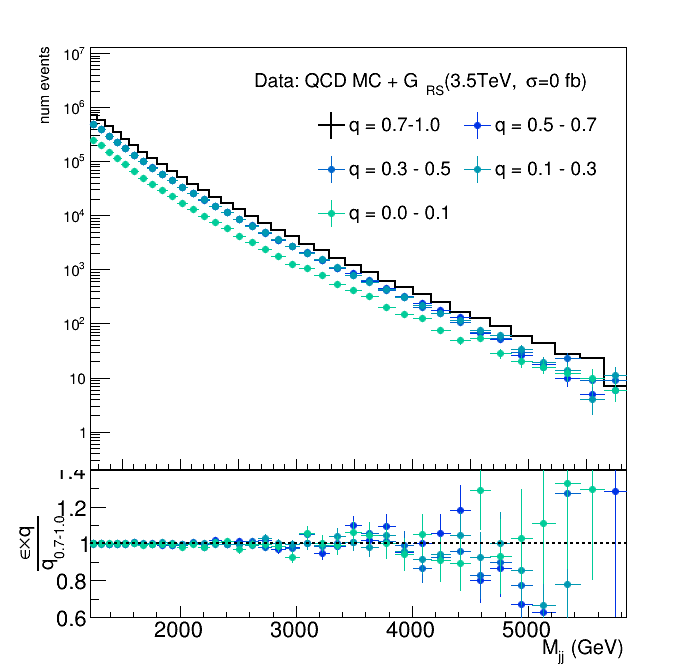

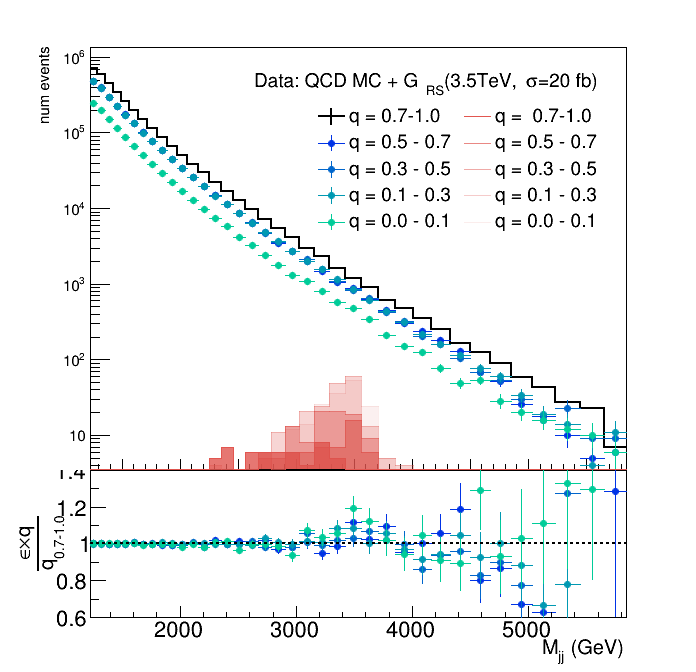

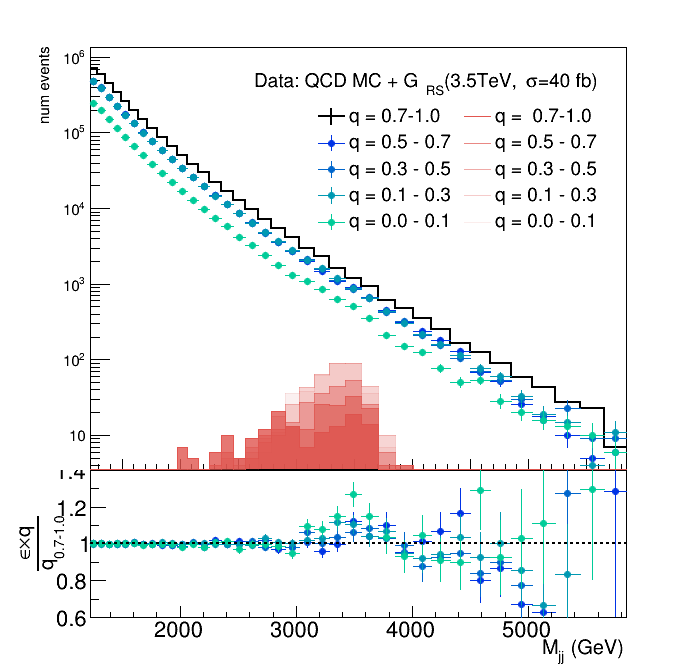

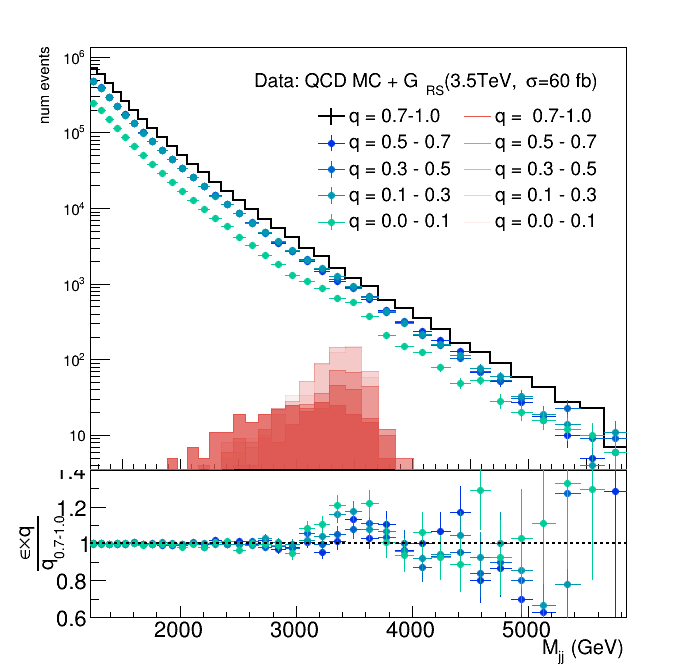

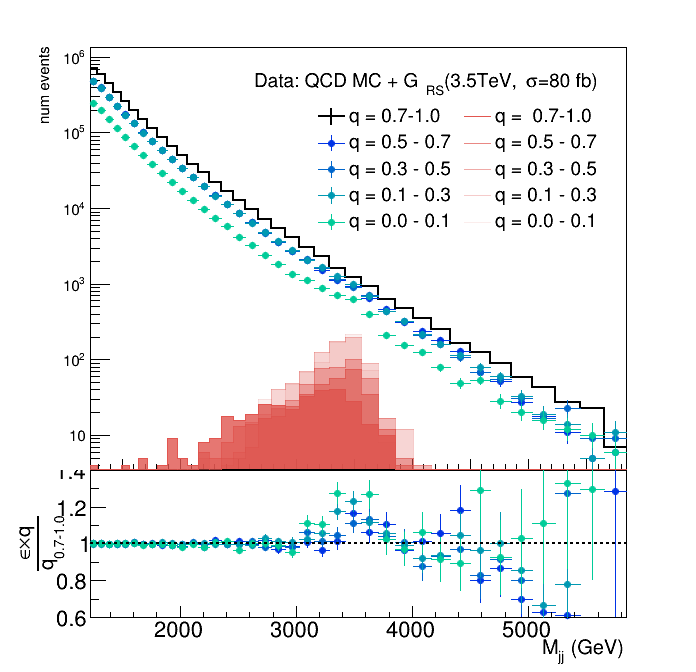

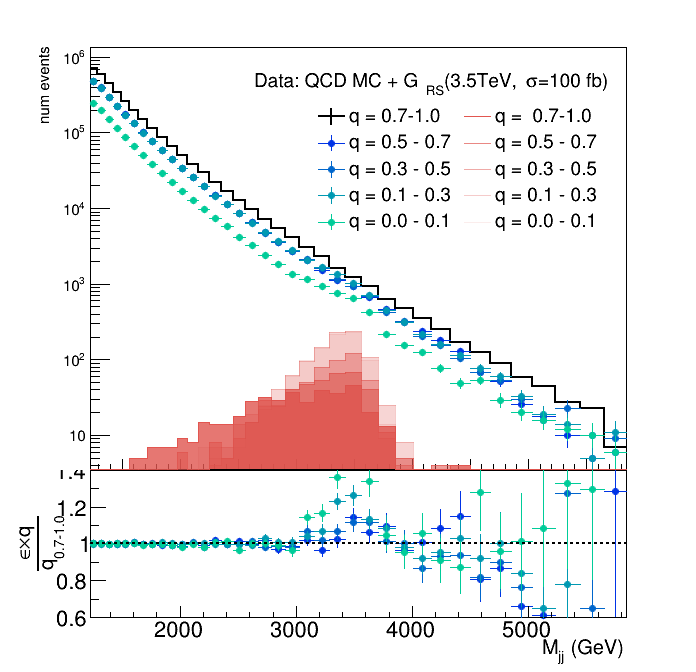

In [16]:
import cmsstyle #mplhep for Python2 cheatsheet

# for each signal injection value
for sig_inj in sig_injs:

    c_out, pad1, pad2 = rpu.create_canvas_pads(pad_props={'LeftMargin': 0.13})
    
    # legend
    leg = rpu.create_object("TLegend", 0.45, 0.5, 0.87, 0.78)
    leg.SetNColumns(2)
    leg_h = rpu.create_object("TLegend", 0.35, 0.8, 0.95, 0.85) # second legend for header because left align not available
    rpu.set_style(leg,props={'TextSize': 0.045})
    rpu.set_style(leg_h,props={'TextSize': 0.045})

    ### plot data histograms

    pad1.cd()

    # draw template bottom quantile data and signal histogram
    ht = histos_data_inj[template_q][sig_inj] 
    ht.Draw('HIST')
    leg.AddEntry(ht, 'q = '+q_str_leg[template_q_idx+1]+'-'+q_str_leg[template_q_idx], 'lep')
    # sig_inj histo at xsec 0 can not be empyt, so filled with 10fb, so have to guard plotting each time :|
    if sig_inj != 0:
        hs = histos_sig_inj[template_q][sig_inj]
        hs.Draw('hist same')
        leg.AddEntry(hs, 'q =  '+q_str_leg[template_q_idx+1]+'-'+q_str_leg[template_q_idx], 'l')


    # draw all other quantile histograms
    for q, q_str_i, q_str_ii in zip(quantiles_inv[template_q_idx+1:], q_str_leg[template_q_idx+2:], q_str_leg[template_q_idx+1:]):
        # data
        h = histos_data_inj[q][sig_inj]
        h.Draw('same')
        leg.AddEntry(h, 'q = {} - {}'.format(q_str_i,q_str_ii), 'lep')
        # signal
        if sig_inj != 0:
            hs = histos_sig_inj[q][sig_inj]
            hs.Draw('hist same')
            leg.AddEntry(hs, 'q = {} - {}'.format(q_str_i,q_str_ii), 'l')

    leg_h.SetHeader(r'Data: QCD MC + G_{RS}(%.1fTeV, #sigma=%i fb)'%(mX,sig_inj*10))
    leg.Draw()
    leg_h.Draw()

    # create ratio histograms
    hr = []
    for q, c in zip(quantiles_inv[template_q_idx+1:], cmap_qcd):
        h = histos_data_inj[q][sig_inj]
        props={"LineColor": rt.TColor.GetColor(c), "MarkerColor": rt.TColor.GetColor(c), "Title": '', "LineWidth": 1, "MarkerStyle": marker_sty}
        r = rpu.create_ratio_hist(h,histos_data_inj[template_q][sig_inj],props=props)
        hr.append(r)
    rpu.set_style(hr[0], props={ "XTitle": 'M_{jj} [GeV]', "YTitle": "ratio SIG / BG"})

    pad2.cd()
    hr[0].Draw('pe')
    props={'YTitle':'#frac{#epsilon#timesq}{q_{'+q_str_leg[template_q_idx+1]+'-'+q_str_leg[template_q_idx]+'}}', 'XTitle':'M_{jj} (GeV)', 'Maximum':1.4, 'Minimum':0.6, 'TitleOffset':0.2}
    rpu.set_style(hr[0],props=props)
    rpu.set_style(hr[0].GetYaxis(),props={'TitleSize':0.11, 'LabelSize':0.12, 'Ndivisions':304, 'TitleOffset':0.4 })
    rpu.set_style(hr[0].GetXaxis(),props={'TitleSize':0.11, 'LabelSize':0.12, 'Ndivisions':304, 'TitleOffset':0.95, 'Ndivisions':909, 'TickSize':0.07 })
    hr[0].GetYaxis().CenterTitle()

    for r in hr[1:]:
        r.Draw('pe same')

    eff_line = rpu.create_ratio_line(hr[0])
    eff_line.Draw('same')

    c_out.Draw()
    c_out.SaveAs('fig/mjj_ratio_inj_sig_xsec_{}_qr_run{}.pdf'.format(sig_inj*10, params.qr_run_n))

In [17]:
for inj in sig_injs:
    
    sum_sig_inj = sum(histos_sig_inj[q][inj].Integral() for q in quantiles_inv[template_q_idx:])
    sum_data = sum(histos_data_inj[q][inj].Integral() for q in quantiles_inv[template_q_idx:])

    for q in quantiles_inv[template_q_idx:]:
        print('sig inj {}, q {}: {} signal events'.format(inj, q, histos_sig_inj[q][inj].Integral()))

    print('total injected sig events for xsec {}: {} ({:.4f}% of {} data events)'.format(inj*10, sum_sig_inj, (sum_sig_inj/sum_data)*100, sum_data))


sig inj 0, q 1.0: 56.0 signal events
sig inj 0, q 0.7: 43.0 signal events
sig inj 0, q 0.5: 57.0 signal events
sig inj 0, q 0.3: 117.0 signal events
sig inj 0, q 0.1: 101.0 signal events
total injected sig events for xsec 0: 374.0 (0.0035% of 10615665.0 data events)
sig inj 2, q 1.0: 78.0 signal events
sig inj 2, q 0.7: 66.0 signal events
sig inj 2, q 0.5: 115.0 signal events
sig inj 2, q 0.3: 214.0 signal events
sig inj 2, q 0.1: 180.0 signal events
total injected sig events for xsec 20: 653.0 (0.0062% of 10616318.0 data events)
sig inj 4, q 1.0: 173.0 signal events
sig inj 4, q 0.7: 189.0 signal events
sig inj 4, q 0.5: 253.0 signal events
sig inj 4, q 0.3: 413.0 signal events
sig inj 4, q 0.1: 394.0 signal events
total injected sig events for xsec 40: 1422.0 (0.0134% of 10617087.0 data events)
sig inj 6, q 1.0: 266.0 signal events
sig inj 6, q 0.7: 238.0 signal events
sig inj 6, q 0.5: 331.0 signal events
sig inj 6, q 0.3: 613.0 signal events
sig inj 6, q 0.1: 562.0 signal events
to

## write out histogram files

In [71]:
quantiles_inv

[1.0, 0.7, 0.5, 0.3, 0.1]

In [21]:
# Make one file for shortcut-data
tag = 'PDinj_NA3p5'

sig_injs = [0,2,4,6,8,10]

outfile = rt.TFile("histograms_injSig_{}.root".format(tag), 'RECREATE' )

for si in sig_injs:
    xs = 10*si    
    for q in quantiles_inv[template_q_idx:]:
        quantile = int(q*100)
        # treat special case when bottom q is bounded on the left: in gof name is hardcoded to q100, so change the name
        if template_q_idx == 1 and q == 0.9: quantile = 100
        print("For xsec {}, q {}".format(xs,quantile))
        histos_data_inj[q][si].Write('data_acc_{}fb_q{}p'.format(xs,quantile))
        histos_sig_inj[q][si].Write('signal_acc_{}fb_q{}p'.format(xs,quantile))

outfile.Close() 

For xsec 0, q 100


AttributeError: 'CPyCppyy_NoneType' object has no attribute 'Write'